# Постройте модель классификации: Вкусные азиатские и индийские кухни


## Классификаторы кухни 1

В этом уроке мы изучим различные классификаторы, чтобы *предсказать национальную кухню на основе набора ингредиентов.* При этом мы узнаем больше о том, как алгоритмы могут быть использованы для задач классификации.

### [**Квиз перед лекцией**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Подготовка**

Этот урок основан на [предыдущем уроке](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), где мы:

-   Сделали легкое введение в классификацию, используя набор данных о всех замечательных кухнях Азии и Индии 😋.

-   Изучили некоторые [глаголы dplyr](https://dplyr.tidyverse.org/) для подготовки и очистки данных.

-   Создали красивые визуализации с помощью ggplot2.

-   Показали, как справляться с несбалансированными данными, предварительно обработав их с помощью [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Продемонстрировали, как `prep` и `bake` наш рецепт, чтобы убедиться, что он работает как задумано.

#### **Предварительные требования**

Для этого урока нам понадобятся следующие пакеты для очистки, подготовки и визуализации данных:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) — это [коллекция пакетов для R](https://www.tidyverse.org/packages), разработанная для того, чтобы сделать работу с данными быстрее, проще и интереснее!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) — это [фреймворк](https://www.tidymodels.org/packages/), представляющий собой коллекцию пакетов для моделирования и машинного обучения.

-   `themis`: [пакет themis](https://themis.tidymodels.org/) предоставляет дополнительные шаги для обработки несбалансированных данных.

-   `nnet`: [пакет nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) предоставляет функции для оценки нейронных сетей прямого распространения с одним скрытым слоем, а также для моделей многономиальной логистической регрессии.

Вы можете установить их следующим образом:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

В качестве альтернативы, скрипт ниже проверяет, установлены ли у вас пакеты, необходимые для выполнения этого модуля, и устанавливает их, если они отсутствуют.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Разделите данные на обучающую и тестовую выборки.

Начнем с выполнения нескольких шагов из нашего предыдущего урока.

### Удалите самые распространенные ингредиенты, которые вызывают путаницу между различными кухнями, с помощью `dplyr::select()`.

Все обожают рис, чеснок и имбирь!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


Отлично! Теперь нужно разделить данные так, чтобы 70% данных пошли на обучение, а 30% — на тестирование. Мы также применим технику `стратификации` при разделении данных, чтобы `сохранить пропорции каждой кухни` в обучающем и валидационном наборах данных.

[rsample](https://rsample.tidymodels.org/), пакет из Tidymodels, предоставляет инфраструктуру для эффективного разделения данных и повторной выборки:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. Работа с несбалансированными данными

Как вы могли заметить в исходном наборе данных, а также в нашем обучающем наборе, распределение количества кухонь довольно неравномерное. Корейская кухня представлена *почти* в 3 раза больше, чем тайская. Несбалансированные данные часто негативно влияют на производительность модели. Многие модели работают лучше, когда количество наблюдений равно, и, следовательно, испытывают трудности с обработкой несбалансированных данных.

Существует два основных способа работы с несбалансированными наборами данных:

-   добавление наблюдений к меньшинству: `Over-sampling`, например, использование алгоритма SMOTE, который синтетически генерирует новые примеры для меньшинства, используя ближайших соседей этих случаев.

-   удаление наблюдений из большинства: `Under-sampling`

В нашем предыдущем уроке мы показали, как работать с несбалансированными наборами данных, используя `recipe`. Recipe можно рассматривать как план, описывающий, какие шаги следует применить к набору данных, чтобы подготовить его к анализу. В нашем случае мы хотим добиться равного распределения количества кухонь в нашем `training set`. Давайте приступим!


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Вы можете, конечно, подтвердить (используя prep+bake), что рецепт будет работать так, как вы ожидаете, — все метки кухни имеют `559` наблюдений.

Поскольку мы будем использовать этот рецепт как препроцессор для моделирования, `workflow()` выполнит всю подготовку и обработку за нас, так что нам не придется вручную оценивать рецепт.

Теперь мы готовы обучить модель 👩‍💻👨‍💻!

## 3. Выбор классификатора

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Иллюстрация от @allison_horst</figcaption>


Теперь нам нужно решить, какой алгоритм использовать для задачи 🤔.

В Tidymodels пакет [`parsnip`](https://parsnip.tidymodels.org/index.html) предоставляет единый интерфейс для работы с моделями на разных движках (пакетах). Ознакомьтесь с документацией parsnip, чтобы изучить [типы моделей и движки](https://www.tidymodels.org/find/parsnip/#models), а также их соответствующие [аргументы моделей](https://www.tidymodels.org/find/parsnip/#model-args). Разнообразие может показаться ошеломляющим на первый взгляд. Например, следующие методы включают техники классификации:

-   Модели классификации на основе правил C5.0

-   Гибкие дискриминантные модели

-   Линейные дискриминантные модели

-   Регуляризованные дискриминантные модели

-   Модели логистической регрессии

-   Модели мультиномиальной регрессии

-   Модели наивного Байеса

-   Машины опорных векторов

-   Ближайшие соседи

-   Деревья решений

-   Ансамблевые методы

-   Нейронные сети

И это еще не все!

### **Какой классификатор выбрать?**

Итак, какой классификатор стоит выбрать? Часто полезно протестировать несколько вариантов и выбрать тот, который дает хороший результат.

> AutoML решает эту задачу, выполняя сравнения в облаке, что позволяет выбрать лучший алгоритм для ваших данных. Попробуйте [здесь](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Кроме того, выбор классификатора зависит от нашей задачи. Например, если результат можно разделить на `более чем два класса`, как в нашем случае, необходимо использовать `алгоритм многоклассовой классификации`, а не `бинарную классификацию`.

### **Лучший подход**

Лучший способ, чем просто угадывать, — это следовать рекомендациям из этого загружаемого [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Здесь мы узнаем, что для нашей задачи многоклассовой классификации у нас есть несколько вариантов:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Раздел шпаргалки Microsoft по алгоритмам, описывающий варианты многоклассовой классификации</figcaption>


### **Обоснование**

Давайте попробуем рассмотреть различные подходы, учитывая имеющиеся ограничения:

-   **Глубокие нейронные сети слишком тяжелы**. Учитывая наш чистый, но минимальный набор данных, а также то, что обучение проводится локально через ноутбуки, глубокие нейронные сети слишком громоздки для этой задачи.

-   **Двухклассовый классификатор не подходит**. Мы не используем двухклассовый классификатор, поэтому метод "один против всех" исключается.

-   **Дерево решений или логистическая регрессия могут подойти**. Дерево решений может быть подходящим вариантом, как и многономинальная регрессия/многоклассовая логистическая регрессия для многоклассовых данных.

-   **Многоклассовые усиленные деревья решений решают другую задачу**. Многоклассовое усиленное дерево решений лучше всего подходит для непараметрических задач, например, задач, направленных на построение ранжирования, поэтому оно нам не подходит.

Кроме того, обычно перед тем, как приступать к более сложным моделям машинного обучения, например, ансамблевым методам, полезно построить максимально простую модель, чтобы понять, что происходит. Поэтому в этом уроке мы начнем с модели `многономинальной регрессии`.

> Логистическая регрессия — это метод, используемый, когда переменная результата является категориальной (или номинальной). Для бинарной логистической регрессии количество переменных результата равно двум, тогда как для многономинальной логистической регрессии количество переменных результата превышает два. См. [Advanced Regression Methods](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) для дальнейшего изучения.

## 4. Обучение и оценка модели многономинальной логистической регрессии.

В Tidymodels, `parsnip::multinom_reg()` определяет модель, которая использует линейные предикторы для прогнозирования многоклассовых данных с использованием многономинального распределения. См. `?multinom_reg()` для различных способов/движков, которые можно использовать для обучения этой модели.

Для этого примера мы обучим модель многономинальной регрессии с использованием стандартного движка [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Я выбрал значение для `penalty` довольно случайно. Существуют более эффективные способы выбора этого значения, например, с использованием `resampling` и `tuning` модели, о которых мы поговорим позже.
>
> См. [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/), если хотите узнать больше о настройке гиперпараметров модели.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Отличная работа 🥳! Теперь, когда у нас есть рецепт и спецификация модели, нам нужно найти способ объединить их в объект, который сначала будет предварительно обрабатывать данные, затем обучать модель на предварительно обработанных данных, а также позволит выполнять потенциальные действия по постобработке. В Tidymodels этот удобный объект называется [`workflow`](https://workflows.tidymodels.org/) и удобно хранит ваши компоненты моделирования! Это то, что мы бы назвали *пайплайнами* в *Python*.

Итак, давайте объединим всё в workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Рабочие процессы 👌👌! **`workflow()`** можно настроить почти так же, как и модель. Итак, время обучить модель!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Вывод показывает коэффициенты, которые модель выучила во время обучения.

### Оценка обученной модели

Пришло время узнать, как модель справилась 📏, оценив её на тестовом наборе данных! Давайте начнем с прогнозов на тестовом наборе.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


Отличная работа! В Tidymodels оценка производительности модели может быть выполнена с помощью [yardstick](https://yardstick.tidymodels.org/) - пакета, используемого для измерения эффективности моделей с помощью метрик производительности. Как мы делали в уроке по логистической регрессии, давайте начнем с вычисления матрицы ошибок.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

При работе с несколькими классами обычно более удобно визуализировать это в виде тепловой карты, как это:


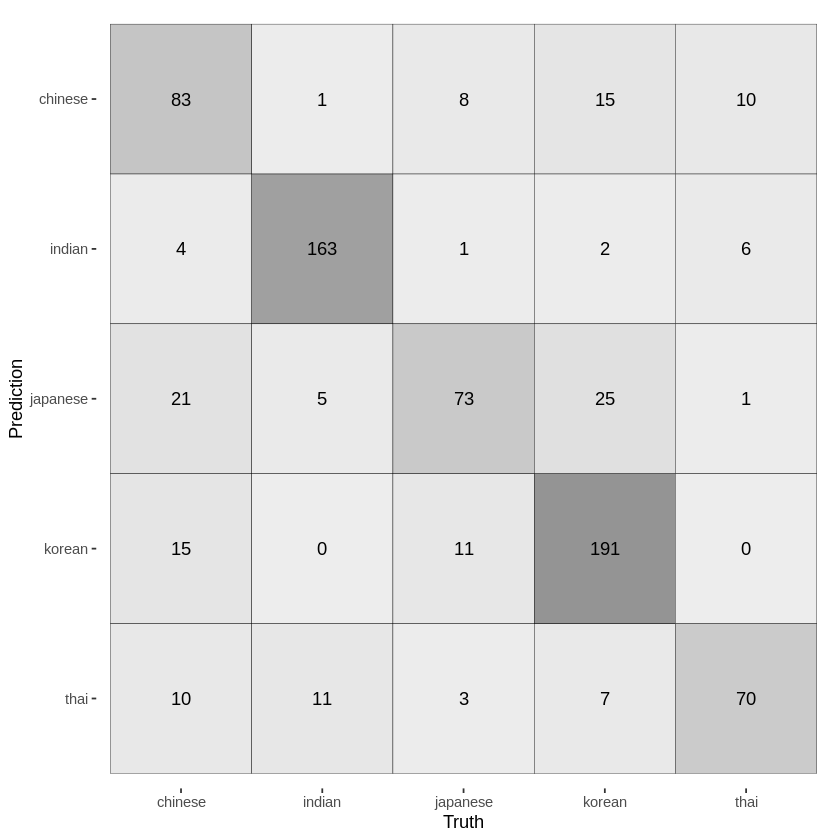

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Более тёмные квадраты на графике матрицы ошибок указывают на большое количество случаев, и, возможно, вы заметите диагональную линию из более тёмных квадратов, которая показывает случаи, когда предсказанная и фактическая метка совпадают.

Теперь давайте рассчитаем сводные статистические данные для матрицы ошибок.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


Если мы сосредоточимся на таких метриках, как точность, чувствительность, PPV, то для начала у нас всё не так уж плохо 🥳!

## 4. Углубляемся

Давайте зададим один тонкий вопрос: какие критерии используются, чтобы выбрать определённый тип кухни в качестве предсказанного результата?

Итак, статистические алгоритмы машинного обучения, такие как логистическая регрессия, основаны на `вероятности`; то есть то, что на самом деле предсказывает классификатор, — это распределение вероятностей по набору возможных исходов. Класс с наивысшей вероятностью затем выбирается как наиболее вероятный результат для данных наблюдений.

Давайте посмотрим, как это работает, сделав как жёсткие предсказания классов, так и вероятностные.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


✅ Можете объяснить, почему модель уверена, что первое наблюдение относится к тайской кухне?

## **🚀Задача**

В этом уроке вы использовали очищенные данные для создания модели машинного обучения, которая может предсказывать национальную кухню на основе набора ингредиентов. Потратьте время, чтобы изучить [множество вариантов](https://www.tidymodels.org/find/parsnip/#models), которые предоставляет Tidymodels для классификации данных, а также [другие способы](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) настройки многономиальной регрессии.

#### СПАСИБО:

[`Эллисон Хорст`](https://twitter.com/allison_horst/) за создание удивительных иллюстраций, которые делают R более доступным и увлекательным. Найдите больше иллюстраций в её [галерее](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Кэсси Бревью](https://www.twitter.com/cassieview) и [Джен Лупер](https://www.twitter.com/jenlooper) за создание оригинальной версии этого модуля на Python ♥️

<br>
Хотел бы добавить пару шуток, но я не понимаю каламбуры про еду 😅.

<br>

Приятного обучения,

[Эрик](https://twitter.com/ericntay), Золотой студент-амбассадор Microsoft Learn.



---

**Отказ от ответственности**:  
Этот документ был переведен с помощью сервиса автоматического перевода [Co-op Translator](https://github.com/Azure/co-op-translator). Несмотря на наши усилия обеспечить точность, автоматические переводы могут содержать ошибки или неточности. Оригинальный документ на его родном языке следует считать авторитетным источником. Для получения критически важной информации рекомендуется профессиональный перевод человеком. Мы не несем ответственности за любые недоразумения или неправильные интерпретации, возникшие в результате использования данного перевода.
